## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle

#### User Input Data


In [2]:
path_training_dataset = "D:\\Work\\Sarbazi\\data\\all_data\\training"
path_testing_dataset = "D:\\Work\\Sarbazi\\data\\all_data\\testing"
batch_size = 2
femur_locator = True
if femur_locator:
    # for femur locator
    image_shape = (1024//2, 1024//2)
    crop_enabled = False
    naugment = 1
else:
    # for accurate segmentation
    image_shape = (1024//2, 768//2)
    crop_enabled = True
    naugment = 4

#### Data Generation


In [3]:
MyUtils = reload(MyUtils)
training_data = MyUtils.DataGenerator(path_training_dataset, batch_size, image_shape, crop_enabled, naugment, True, True)
testing_data = MyUtils.DataGenerator(path_testing_dataset, batch_size, image_shape, crop_enabled, naugment, False, True)

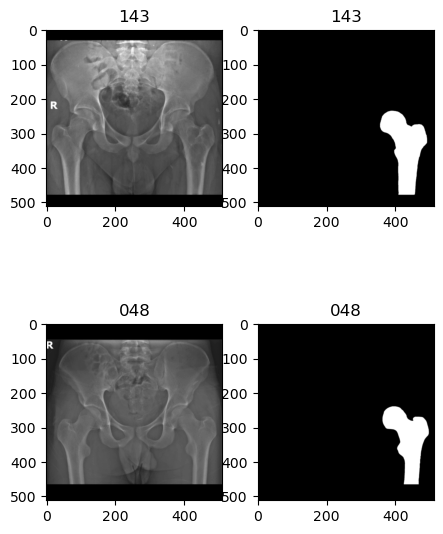

In [20]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(sample_batch_image.shape[0], 2, figsize=(5, 7))
for i in range(sample_batch_image.shape[0]):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i//naugment]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i//naugment]).zfill(3))

#### Create U-Net


In [5]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
if femur_locator:
    UNetModel = UNet.create_UNet_locator((*image_shape,1), (*image_shape,1))
else:
    UNetModel = UNet.create_UNet_accurate((*image_shape,1), (*image_shape,1))
UNetModel.compile(optimizer=MyUtils.keras.optimizers.Adam(), loss=MyUtils.keras.losses.BinaryCrossentropy())
# UNetModel.compile(optimizer=MyUtils.keras.optimizers.Adam(), loss=MyUtils.dice_coef_loss)
# UNetModel.summary(line_length=120)

In [34]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=10, workers=10, verbose=0)

In [35]:
if femur_locator:
    UNetModel.save('UNetModel_locator.h5')
else:
    UNetModel.save('UNetModel_accurate.h5')

In [64]:
if femur_locator:
    UNetModel = UNet.keras_models.load_model('UNetModel_locator.h5')
else:
    UNetModel = UNet.keras_models.load_model('UNetModel_accurate.h5')

1/1 [==============================] - 0s 22ms/step


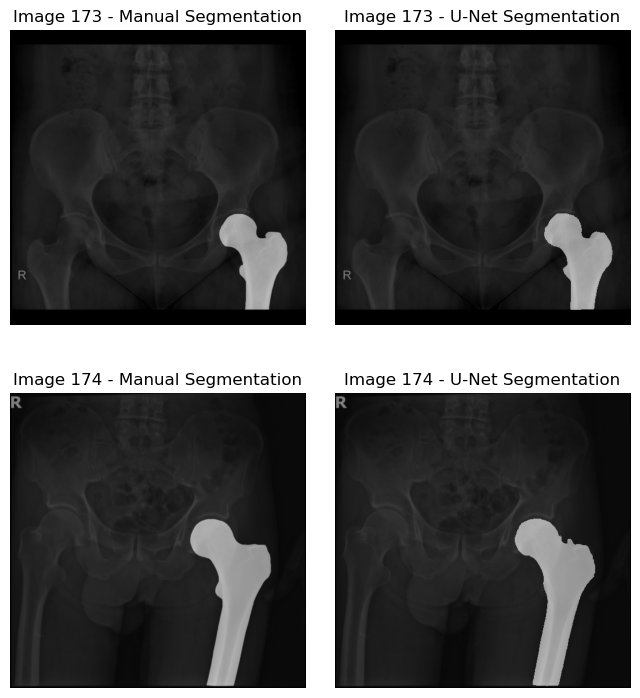

In [36]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,9))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i//naugment]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i//naugment]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [37]:
# with open('out.png','wb') as f:
#     fig.savefig(f, dpi=600)

## evaluation on selected dataset


In [38]:
eval_data = testing_data
gdth_img = []
pred_img = []
for i in range(len(eval_data)):
    images, masks = eval_data[i]
    predict_segment = UNetModel.predict(images, verbose=0)
    predict_segment = (predict_segment>0.5).astype(np.int_)
    for m in range(masks.shape[0]):
        gdth_img.append(masks[m,:,:,0])
        pred_img.append(predict_segment[m,:,:,0])

In [39]:
import seg_metrics.seg_metrics as sg
labels = [0, 1]
spacing = [0.3, 0.3]
metrics = sg.write_metrics(labels=labels[1:],  # exclude background if needed
                          gdth_img=gdth_img,
                          pred_img=pred_img,
                          spacing=spacing)

43it [00:09,  4.65it/s]


In [40]:
mean_metrics = {} 
std_metrics = {}
for m in metrics:
    for k in m.keys():
        try:
            mean_metrics[k].append(m[k][0])
        except:
            mean_metrics[k] = []
            mean_metrics[k].append(m[k][0])
std_metrics = mean_metrics.copy()
for k in mean_metrics.keys():
    mean_metrics[k] = np.round(np.mean(mean_metrics[k]), decimals=2)
    std_metrics[k] = np.round(np.std(std_metrics[k]), decimals=2)



In [41]:
mean_metrics

{'label': 1.0,
 'dice': 0.94,
 'jaccard': 0.89,
 'precision': 0.9,
 'recall': 0.99,
 'fpr': 0.01,
 'fnr': 0.01,
 'vs': -0.1,
 'hd': 8.91,
 'msd': 0.8,
 'mdsd': 0.61,
 'stdsd': 0.93,
 'hd95': 2.3}

In [42]:
std_metrics

{'label': 0.0,
 'dice': 0.02,
 'jaccard': 0.03,
 'precision': 0.03,
 'recall': 0.01,
 'fpr': 0.0,
 'fnr': 0.01,
 'vs': 0.04,
 'hd': 22.45,
 'msd': 0.72,
 'mdsd': 0.05,
 'stdsd': 1.78,
 'hd95': 4.75}